# Model test, feature extraction and class activation map(CAM)

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import sklearn.metrics
from skimage.measure import label
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import copy
import glob
import ntpath
import pandas as pd

# Dataset including paths

We want to include the filenames of images for prediction output

In [2]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [21]:
# Data augmentation and normalization for training
# Just normalization for validation
# Note that for test: please make a subdirectory under data_dir with the name of one of the classes and put 
# all the test images under the subdirectory
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
}

data_dir = 'kaggle_data_normal'
image_datasets = {x: ImageFolderWithPaths(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
#set batch size
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('use GPU:{}'.format(torch.cuda.is_available()))

use GPU:True


# Function: Test the model

In [4]:
def output_sample_csv(model, csv_filename):
    '''output the prediction scores to csv file'''
    sftm = nn.Softmax()
    sftm.to(device)
    for i, (inputs, labels, paths) in enumerate(dataloaders['all_tests']):
        inputs = inputs.to(device)
        
        outputs = model(inputs)
        outputs = sftm(outputs)
        for j in range(inputs.size()[0]):
            y = outputs.cpu().data[j,0]
            filename = ntpath.basename(paths[j])
            filename = filename.split('.')[0]
            submission.loc[filename]['label'] = y
    submission.to_csv(csv_filename)
        

# Function: Heatmap and bounding box(Please change device to CPU for the sake of memory space before using this)

In [77]:
def im(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # The input is CXHXW, the output is HXWXC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp


def plot_activ(model, num_images=4):
    """Heatmaps for batches of images loaded from dataloaders"""
    weights = model.fc.weight # size[2,2048]
    resnet_conv = nn.Sequential(*list(model.children())[:-2])
    m = nn.Upsample(size=(224,224), mode='bilinear') 
    m = m.to(device) # define the operation of upsampling to the image size
    images_so_far = 0
    for i, (inputs, labels, _) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        batch_size = inputs.size()[0]
        outputs = model(inputs)
        last_conv_outputs = resnet_conv(inputs)# size[batch_size, 2048, 7, 7]
        act_maps = m(last_conv_outputs)# size[batch_size, 2048, 224, 224]
        scores, preds = torch.max(outputs, 1)
        
        for j in range(batch_size):
            out = torch.zeros(224,224)
            for k in range(2048):
                out = out + weights[preds[j]][k]*act_maps[j,k,:,:]
            images_so_far += 1
            ax = plt.subplot(num_images, 2, images_so_far*2-1)
            ax.set_title('{}:{}'.format(class_names[preds[j]], scores[j]))
            ax.imshow(im(inputs.cpu().data[j]))
            ax.imshow(out.cpu().data, cmap='jet', alpha=0.35)
            ax.axis('off')
            ax2 = plt.subplot(num_images, 2, images_so_far*2)
            ax2.imshow(im(inputs.cpu().data[j]))
            ax2.set_title('{}:{}'.format(class_names[preds[j]], scores[j]))
            ax2.axis('off')
            if images_so_far == num_images:
                return
            
def plot_cam_given(model, image_path, filename=None):
    '''heatmap and bonding box for one image'''
    
    img = Image.open(image_path).convert('RGB')# note that this was a grayscale image
    img_tensor = data_transforms['val'](img).view(1,3,224,224)
    weights = model.fc.weight # size[2,2048]
    resnet_conv = nn.Sequential(*list(model.children())[:-2])
    
    # define the operation of upsampling to the image size
    m = nn.Upsample(size=(224,224), mode='bilinear') 
    # define the operation of softmax to get the probability of each class
    sftm = nn.Softmax()
    
    m = m.to(device) 
    sftm = sftm.to(device)
    img_tensor = img_tensor.to(device)
    
    output = model(img_tensor)
    
    scores = sftm(output)
    last_conv_output = resnet_conv(img_tensor)
    act_maps = m(last_conv_output)
    pred = torch.argmax(scores)
    out = torch.zeros(224,224)
    
    # weighted sum of activation maps
    for k in range(2048):
        out = out + weights[pred, k]*torch.squeeze(act_maps[0,k,:,:])
    
    # original image vs image with heatmap, side by side plot   
    plt.figure(figsize=(7,4))
    
    ax = plt.subplot(121)
    ax.set_aspect(1)
    plt.imshow(img)
    plt.title('original image')
    plt.axis('off')
    
    ax2 = plt.subplot(122)
    plt.imshow(img)
    plt.imshow(out.cpu().data, cmap='jet', alpha=0.35)
    plt.axis('off')
    plt.title('{}:{}'.format(class_names[pred], scores.cpu().data[0][pred]))
    left, bottom, width, height = bbox(out.numpy())
    # Create a Rectangle patch
    rect = patches.Rectangle((left,bottom),width,height,linewidth=2,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    ax2.add_patch(rect)
    plt.show()
    
        
def bbox(heatmap, threshold=0.5):
    '''
        heatmap: a numpy array
        return: left, bottom indices, and width, height of the box
    '''
    m = heatmap.max()
    mask = 1*np.array(heatmap>threshold*m)
    labels = label(mask)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    Icol = largestCC.sum(axis=0)>0
    Irow = largestCC.sum(axis=1)>0
    colIndices = np.where(Icol)[0]
    rowIndices = np.where(Irow)[0]
    left = colIndices[0]
    right = colIndices[colIndices.size-1]
    top = rowIndices[0]
    bottom = rowIndices[rowIndices.size-1]
    return left, bottom, right-left, top-bottom
    

# Define the model and load the checkpoint file

In [6]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# checkpoint_dir = 'resnet_checkpoints'
# if not os.listdir(checkpoint_dir):
#     list_of_files = glob.glob(os.path.join(checkpoint_dir,'*.pt'))
#     latest_file = max(list_of_files, key=os.path.getctime)
#     model_ft.load_state_dict(torch.load(latest_file))
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft= model_ft.to(device)
model_ft.load_state_dict(torch.load('50_final_normal_14_epoch_from_pretrained'))

2048


<All keys matched successfully>

# Test and output the submission file named 'submission'

In [7]:
model_ft.eval()
for param in model_ft.parameters():
    param.requires_grad = False

In [8]:
submission = pd.read_csv('sample_submission.csv', index_col='id')

In [9]:
submission = submission.astype({'label':'float32'})
submission.dtypes

label    float32
dtype: object

In [10]:
output_sample_csv(model_ft, 'submission2')

/home/cly/python_projects/python_projects_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


# Output features to csv file

This module extracts the output of the layer before the last layer and writes to a csv file for anomaly filtering use.

In [11]:
def output_features(model, num_ftrs, phase, suffix):
    '''output features before the fully connected layers to csv file named 'phasesuffix' '''
    
    f=open(phase+suffix,'w')
    images_so_far = 0
    num_classes = len(class_names)
    for i, (inputs, labels, paths) in enumerate(dataloaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        
        for j in range(inputs.size()[0]):
            y = np.zeros(num_ftrs+1)
            y[0] = labels.cpu()[j]
            y[1:] = np.reshape(outputs.cpu().data[j],[1,num_ftrs])
            filename = ntpath.basename(paths[j])
            images_so_far +=1
            y_arrstr = np.char.mod('%f', y)
            output = ','.join(y_arrstr)
            output = filename+',' + output +'\n'
            f.write(output)
    f.close()

In [12]:
model_ft= nn.Sequential(*list(model_ft.children())[:-1])
model_ft.eval()
for param in model_ft.parameters():
    param.requires_grad = False

In [22]:
output_features(model_ft, num_ftrs,'train','_pretrained_resnet50_features_final_normal.csv')

# Plot activation map

/home/cly/python_projects/python_projects_env/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


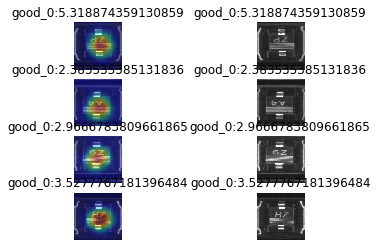

In [19]:
# plot activation maps from images provided by dataloader in a batch
plot_activ(model_ft)

In [50]:
# one particular bad sample
img_path = 'kaggle_data/val/bad_1/2dee00cb9ddb4c0e0daff8aed02aadd4.jpg'


/home/cly/python_projects/python_projects_env/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


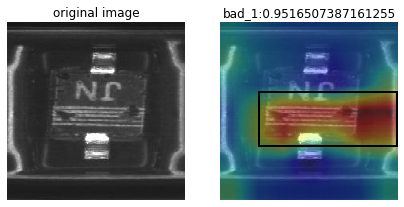

In [78]:
plot_cam_given(model_ft, img_path)